In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# get data
data = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database')
normal_dt = os.path.join(data, 'Normal')
tuber_dt = os.path.join(data, 'Tuberculosis')

In [3]:
def preprocessing(X, y):
    images = []
    labels = []

    for file in os.listdir(X):
        image_path = os.path.join(X, file)
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = image.resize((256, 256))
        image = np.array(image) / 255.0 # normalize pixels

        images.append(image)
        labels.append(y)
    return images, labels

In [4]:
normal_imgs, normal_labels = preprocessing(normal_dt, y=0)
tuber_imgs, tuber_labels = preprocessing(tuber_dt, y=1)

images = normal_imgs + tuber_imgs
labels = normal_labels + tuber_labels

images = np.array(images)
labels = np.array(labels)

In [5]:
# split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print(X_train.shape)

(3360, 256, 256, 3)


# 1. SGD

## 1.1 Train and Evaluate

In [6]:
# training SGD
from sklearn.linear_model import SGDClassifier

X_train_sgd, X_test_sgd = X_train.reshape((len(X_train), 256*256*3)), X_test.reshape((len(X_test), 256*256*3))
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_sgd, y_train)

SGDClassifier(random_state=42)

In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_sgd, y_train, cv=3)
print(confusion_matrix(y_train, y_train_pred))

[[2754   46]
 [  53  507]]


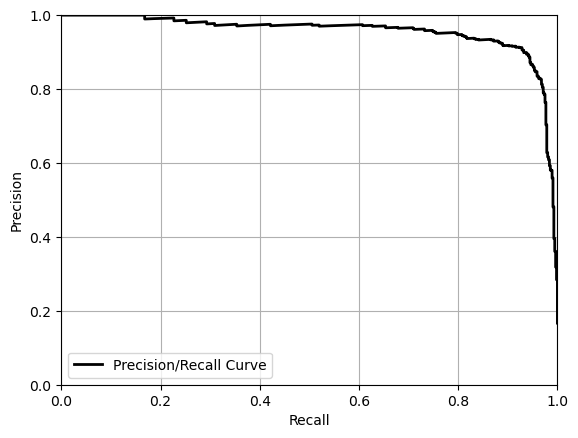

In [8]:
#PR curve
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train_sgd, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

plt.plot(recalls, precisions, "k", label="Precision/Recall Curve", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()
plt.show()

In [99]:
# measuring on test data without optimization
from sklearn.metrics import accuracy_score

y_pred_sgd = sgd_clf.predict(X_test_sgd)
print(f"Precision Score: {precision_score(y_test, y_pred_sgd)}")
print(f"Recall Score: {recall_score(y_test, y_pred_sgd)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_sgd)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd)}")

Precision Score: 0.9626865671641791
Recall Score: 0.9214285714285714
AUC Score: 0.9571428571428571
Accuracy: 0.9809523809523809


## 1.2 Fine Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': np.arange(0.0001, 0.01, 0.001),
}
sgd_clf_best = SGDClassifier(random_state=42)
grid_search = GridSearchCV(sgd_clf_best, param_grid, cv=5)
grid_search.fit(X_train_sgd, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': array([0.0001, 0.0011, 0.0021, 0.0031, 0.0041, 0.0051, 0.0061, 0.0071,
       0.0081, 0.0091])})

In [10]:
print("Best Parameters:", grid_search.best_params_)
best_sgd_clf = grid_search.best_estimator_

Best Parameters: {'alpha': 0.0051}


In [11]:
y_train_pred_best = cross_val_predict(best_sgd_clf, X_train_sgd, y_train, cv=3)
print(confusion_matrix(y_train, y_train_pred_best))

[[2759   41]
 [  65  495]]


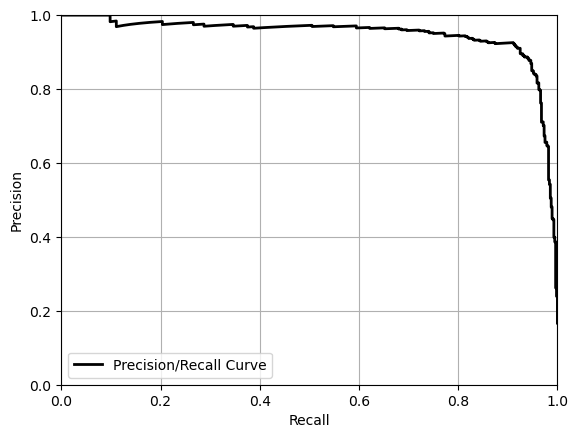

In [12]:
#PR curve
y_scores_best = cross_val_predict(best_sgd_clf, X_train_sgd, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_best)

plt.plot(recalls, precisions, "k", label="Precision/Recall Curve", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()
plt.show()

In [100]:
# evaluate on test set
test_score = best_sgd_clf.score(X_test_sgd, y_test)
print(test_score)

0.969047619047619


In [14]:
y_pred_test_best_sgd = best_sgd_clf.predict(X_test_sgd)

# 2. RandomForestClassifier

## 2.1 Training and Evaluating

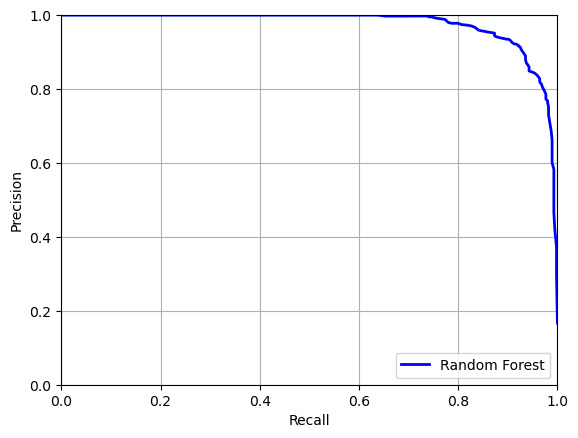

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probs_forest = cross_val_predict(forest_clf, X_train_sgd, y_train, cv=3, method="predict_proba")
y_scores_forest = y_probs_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)

# plotting PR curve
plt.plot(recalls_forest, precisions_forest, "b", label="Random Forest", linewidth=2)
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [16]:
# measuring effectiveness
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score

y_train_pred_forest = (y_probs_forest[:, 1] >= 0.45)
print(f"Precision Score: {precision_score(y_train, y_train_pred_forest)}")
print(f"Recall Score: {recall_score(y_train, y_train_pred_forest)}")
print(f"AUC Score: {roc_auc_score(y_train, y_scores_forest)}")

Precision Score: 0.9287020109689214
Recall Score: 0.9071428571428571
AUC Score: 0.9926431760204082


In [17]:
# Scores are good enough to avoid fine tuning (takes too long for minimal improvement)

## 2.2 Evaluating on Test set

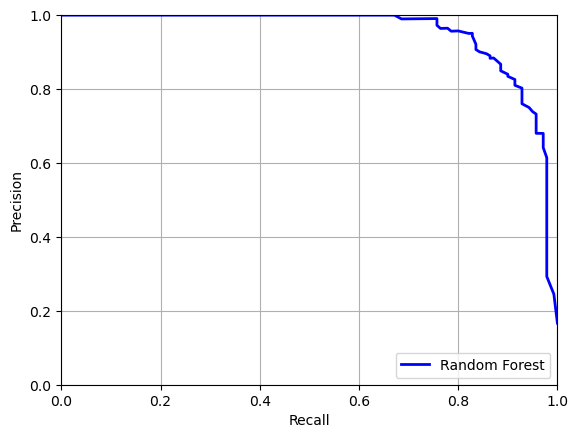

In [18]:
y_probs_forest_test = cross_val_predict(forest_clf, X_test_sgd, y_test, cv=3, method="predict_proba")
y_scores_forest_test = y_probs_forest_test[:, 1]

precisions_forest_test, recalls_forest_test, thresholds_forest_test = precision_recall_curve(y_test, y_scores_forest_test)

# plotting PR curve
plt.plot(recalls_forest_test, precisions_forest_test, "b", label="Random Forest", linewidth=2)
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [19]:
# measuring effectiveness
y_test_pred_forest = (y_probs_forest_test[:, 1] >= 0.45)
print(f"Precision Score: {precision_score(y_test, y_test_pred_forest)}")
print(f"Recall Score: {recall_score(y_test, y_test_pred_forest)}")
print(f"AUC Score: {roc_auc_score(y_test, y_scores_forest_test)}")

Precision Score: 0.9508196721311475
Recall Score: 0.8285714285714286
AUC Score: 0.9791581632653062


In [98]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_forest)}")

Accuracy: 0.9642857142857143


## 2.3 Recap of Evaluation

In [21]:
# Recap so far:
print(f"Precision Score of SGD_clf: {precision_score(y_test, y_pred_test_best_sgd)}")
print(f"Recall Score of SGD_clf: {recall_score(y_test, y_pred_test_best_sgd)}")
print(f"AUC Score of SGD_clf: {roc_auc_score(y_test, y_pred_test_best_sgd)}")

Precision Score of SGD_clf: 0.875
Recall Score of SGD_clf: 0.95
AUC Score of SGD_clf: 0.9614285714285714


In [22]:
y_test_pred_forest = (y_probs_forest_test[:, 1] >= 0.45)
print(f"Precision Score of RFC: {precision_score(y_test, y_test_pred_forest)}")
print(f"Recall Score of RFC: {recall_score(y_test, y_test_pred_forest)}")
print(f"AUC Score of RFC: {roc_auc_score(y_test, y_scores_forest_test)}")

Precision Score of RFC: 0.9508196721311475
Recall Score of RFC: 0.8285714285714286
AUC Score of RFC: 0.9791581632653062


# 3. LinearSVC

## 3.1 Training and Evaluating LinearSVC

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

lin_svc = make_pipeline(StandardScaler(), LinearSVC(dual=True, random_state=42, max_iter=10000))
lin_svc.fit(X_train_sgd, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(max_iter=10000, random_state=42))])

In [39]:
from sklearn.model_selection import cross_val_score

y_scores_svc = lin_svc.predict(X_test_sgd)
print(f"Precision Score: {precision_score(y_test, y_scores_svc)}")
print(f"Recall Score: {recall_score(y_test, y_scores_svc)}")
print(f"AUC Score: {roc_auc_score(y_test, y_scores_svc)}")
print(f"Accuracy: {cross_val_score(lin_svc, X_test_sgd, y_test).mean()}")

Precision Score: 0.9230769230769231
Recall Score: 0.9428571428571428
AUC Score: 0.9635714285714286
Accuracy: 0.9607142857142857


## 3.2 SVC

In [41]:
# build regular SVC and compare
from sklearn.svm import SVC
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train_sgd, y_train).mean()

0.9839285714285715

In [44]:
svm_clf.fit(X_train_sgd, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [45]:
y_scores_svm_clf = svm_clf.predict(X_test_sgd)
print(f"Precision Score: {precision_score(y_test, y_scores_svm_clf)}")
print(f"Recall Score: {recall_score(y_test, y_scores_svm_clf)}")
print(f"AUC Score: {roc_auc_score(y_test, y_scores_svm_clf)}")
print(f"Accuracy: {cross_val_score(svm_clf, X_test_sgd, y_test).mean()}")

Precision Score: 0.9924812030075187
Recall Score: 0.9428571428571428
AUC Score: 0.9707142857142858
Accuracy: 0.9702380952380952


# 4. MLP

## 4.1 Training a Sequential MLP

In [50]:
import tensorflow as tf
tf.random.set_seed(42)

In [76]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256,256,3)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [77]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [78]:
history = model.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test))

Epoch 1/12
105/105 [==============================] - 19s 175ms/step - loss: 5.9255 - accuracy: 0.8476 - val_loss: 2.6956 - val_accuracy: 0.8952
Epoch 2/12
105/105 [==============================] - 18s 167ms/step - loss: 1.5747 - accuracy: 0.9060 - val_loss: 1.0774 - val_accuracy: 0.9119
Epoch 3/12
105/105 [==============================] - 17s 166ms/step - loss: 1.5409 - accuracy: 0.8926 - val_loss: 0.6710 - val_accuracy: 0.9369
Epoch 4/12
105/105 [==============================] - 18s 167ms/step - loss: 0.5237 - accuracy: 0.9423 - val_loss: 0.3495 - val_accuracy: 0.9357
Epoch 5/12
105/105 [==============================] - 17s 166ms/step - loss: 0.4347 - accuracy: 0.9315 - val_loss: 0.8274 - val_accuracy: 0.9167
Epoch 6/12
105/105 [==============================] - 17s 166ms/step - loss: 0.4736 - accuracy: 0.9348 - val_loss: 0.8854 - val_accuracy: 0.9048
Epoch 7/12
105/105 [==============================] - 18s 167ms/step - loss: 0.3207 - accuracy: 0.9423 - val_loss: 0.2366 - val_ac

In [101]:
y_pred_mlp = model.predict(X_test)
y_pred_mlp = (y_pred_mlp > 0.5).astype(int)

print(f"Precision Score: {precision_score(y_test, y_pred_mlp)}")
print(f"Recall Score: {recall_score(y_test, y_pred_mlp)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_mlp)}")
print(f"Accuracy: {model.evaluate(X_test, y_test)[1]}")

27/27 [==============================] - 1s 19ms/step
Precision Score: 0.8471337579617835
Recall Score: 0.95
AUC Score: 0.9578571428571429
27/27 [==============================] - 1s 19ms/step - loss: 0.1034 - accuracy: 0.9631
Accuracy: 0.9630952477455139


## 4.2 Optimization

In [81]:
# optimization
import keras_tuner as kt
tf.keras.backend.clear_session()

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=300)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [82]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=10, overwrite=True, seed=42)
random_search_tuner.search(X_train, y_train, epochs=12,
                           validation_data=(X_test, y_test))

Trial 10 Complete [00h 01m 56s]
val_accuracy: 0.9714285731315613

Best val_accuracy So Far: 0.976190447807312
Total elapsed time: 00h 16m 23s


In [83]:
best_model_mlp = random_search_tuner.get_best_models(num_models=1)[0]
best_model_mlp.fit(X_train, y_train, epochs=12)

Epoch 1/12
105/105 [==============================] - 21s 180ms/step - loss: 0.0927 - accuracy: 0.9670
Epoch 2/12
105/105 [==============================] - 19s 179ms/step - loss: 0.1372 - accuracy: 0.9533
Epoch 3/12
105/105 [==============================] - 19s 179ms/step - loss: 0.1015 - accuracy: 0.9622
Epoch 4/12
105/105 [==============================] - 19s 181ms/step - loss: 0.0939 - accuracy: 0.9649
Epoch 5/12
105/105 [==============================] - 19s 181ms/step - loss: 0.0723 - accuracy: 0.9747
Epoch 6/12
105/105 [==============================] - 19s 181ms/step - loss: 0.0785 - accuracy: 0.9768
Epoch 7/12
105/105 [==============================] - 19s 180ms/step - loss: 0.1361 - accuracy: 0.9568
Epoch 8/12
105/105 [==============================] - 19s 181ms/step - loss: 0.1028 - accuracy: 0.9631
Epoch 9/12
105/105 [==============================] - 19s 181ms/step - loss: 0.0889 - accuracy: 0.9676
Epoch 10/12
105/105 [==============================] - 19s 181ms/step - l

In [84]:
best_model_mlp.evaluate(X_test, y_test)

27/27 [==============================] - 1s 20ms/step - loss: 0.0708 - accuracy: 0.9786


[0.07075493782758713, 0.9785714149475098]

In [90]:
y_test_pred_mlp = best_model_mlp.predict(X_test)
y_pred_binary_mlp = (y_test_pred_mlp > 0.5).astype(int)

print(f"Precision Score: {precision_score(y_test, y_pred_binary_mlp)}")
print(f"Recall Score: {recall_score(y_test, y_pred_binary_mlp)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_binary_mlp)}")

27/27 [==============================] - 1s 20ms/step
Precision Score: 0.9841269841269841
Recall Score: 0.8857142857142857
AUC Score: 0.9414285714285714


# 5. CNN

## 5.1 Building a CNN

In [91]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [92]:
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test))

Epoch 1/12
105/105 [==============================] - 62s 576ms/step - loss: 0.3618 - accuracy: 0.8854 - val_loss: 0.2071 - val_accuracy: 0.9036
Epoch 2/12
105/105 [==============================] - 57s 543ms/step - loss: 0.1113 - accuracy: 0.9613 - val_loss: 0.0838 - val_accuracy: 0.9690
Epoch 3/12
105/105 [==============================] - 57s 545ms/step - loss: 0.0670 - accuracy: 0.9777 - val_loss: 0.1009 - val_accuracy: 0.9595
Epoch 4/12
105/105 [==============================] - 58s 557ms/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.0769 - val_accuracy: 0.9726
Epoch 5/12
105/105 [==============================] - 59s 563ms/step - loss: 0.0278 - accuracy: 0.9890 - val_loss: 0.1406 - val_accuracy: 0.9583
Epoch 6/12
105/105 [==============================] - 60s 567ms/step - loss: 0.0171 - accuracy: 0.9923 - val_loss: 0.0743 - val_accuracy: 0.9869
Epoch 7/12
105/105 [==============================] - 60s 567ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.0716 - val_ac

In [96]:
model_cnn.evaluate(X_test, y_test)

27/27 [==============================] - 4s 148ms/step - loss: 0.0842 - accuracy: 0.9833


[0.08422155678272247, 0.9833333492279053]

In [97]:
y_test_pred_cnn = model_cnn.predict(X_test)
y_pred_binary_cnn = (y_test_pred_cnn > 0.5).astype(int)

print(f"Precision Score: {precision_score(y_test, y_pred_binary_cnn)}")
print(f"Recall Score: {recall_score(y_test, y_pred_binary_cnn)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_binary_cnn)}")

27/27 [==============================] - 4s 148ms/step
Precision Score: 0.9375
Recall Score: 0.9642857142857143
AUC Score: 0.9757142857142856
